In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('parkinson_disease.csv')

df.sample(5)

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
214,71,1,0.80264,0.68852,0.48725,319,318,0.006057,0.000083,0.00141,...,55.3446,59.3221,59.0320,58.8092,62.8283,60.5090,56.4913,47.2246,93.1124,1
236,78,1,0.80997,0.68753,0.55747,237,236,0.008012,0.000448,0.00370,...,4.9903,5.8904,4.3254,2.9923,2.7173,4.8258,10.4754,22.2614,84.1618,0
555,185,1,0.82167,0.71228,0.47668,272,271,0.007091,0.000055,0.00128,...,1.9412,29.7967,18.5182,10.2037,13.9892,24.0845,17.0437,11.9906,10.6872,1
104,34,0,0.80595,0.65901,0.27874,378,377,0.005102,0.000039,0.00117,...,12.1129,5.7066,7.0584,3.8273,2.6012,2.9172,4.8200,8.5949,3.2542,0
364,121,0,0.72457,0.70908,0.57726,169,168,0.011419,0.000093,0.00295,...,2.0736,2.1863,2.0105,7.0822,5.0996,4.8190,3.5347,3.5861,2.6347,1


In [3]:
df.info

<bound method DataFrame.info of       id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
0      0       1  0.85247  0.71826  0.57227        240               239   
1      0       1  0.76686  0.69481  0.53966        234               233   
2      0       1  0.85083  0.67604  0.58982        232               231   
3      1       0  0.41121  0.79672  0.59257        178               177   
4      1       0  0.32790  0.79782  0.53028        236               235   
..   ...     ...      ...      ...      ...        ...               ...   
751  250       0  0.80903  0.56355  0.28385        417               416   
752  250       0  0.16084  0.56499  0.59194        415               413   
753  251       0  0.88389  0.72335  0.46815        381               380   
754  251       0  0.83782  0.74890  0.49823        340               339   
755  251       0  0.81304  0.76471  0.46374        340               339   

     meanPeriodPulses  stdDevPeriodPulses  locPctJitter

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,756.0,125.500000,72.793721,0.000000,62.750000,125.500000,188.250000,251.00000
gender,756.0,0.515873,0.500079,0.000000,0.000000,1.000000,1.000000,1.00000
PPE,756.0,0.746284,0.169294,0.041551,0.762833,0.809655,0.834315,0.90766
DFA,756.0,0.700414,0.069718,0.543500,0.647053,0.700525,0.754985,0.85264
RPDE,756.0,0.489058,0.137442,0.154300,0.386537,0.484355,0.586515,0.87123
...,...,...,...,...,...,...,...,...
tqwt_kurtosisValue_dec_33,756.0,12.375335,16.341665,1.628700,3.114375,4.741450,12.201325,73.53220
tqwt_kurtosisValue_dec_34,756.0,14.799230,15.722502,1.861700,3.665925,6.725700,21.922050,62.00730
tqwt_kurtosisValue_dec_35,756.0,14.751559,14.432979,1.955900,3.741275,7.334250,22.495175,57.54430
tqwt_kurtosisValue_dec_36,756.0,31.481110,34.230991,2.364000,3.948750,10.637250,61.125325,156.42370


In [5]:
df.isnull().sum().sum()

np.int64(0)

In [6]:
df = df.groupby('id').mean().reset_index()
df.drop('id', axis=1, inplace=True)

In [7]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])
        if val > 0.7:
            # If the correlation between the two features is more than 0.7, remove it
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)
            
    df = df[filtered_columns]
df.shape

(252, 287)

In [8]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

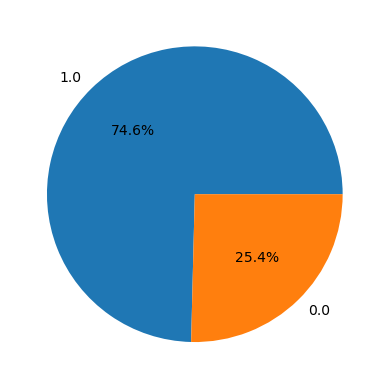

In [9]:
x = df['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show()

In [12]:
features = df.drop('class', axis=1)
target = df['class']


X_train, X_val, y_train, y_val = train_test_split(features, target,
                                                  test_size=0.2,
                                                  random_state=10)

ros = RandomOverSampler(sampling_strategy=1.0, random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

X_resampled.shape, y_resampled.value_counts()

((302, 30),
 class
 1.0    151
 0.0    151
 Name: count, dtype: int64)

In [15]:
from sklearn.metrics import roc_auc_score as ras

# Models list
models = [LogisticRegression(class_weight='balanced'), XGBClassifier(), SVC(kernel='rbf', probability=True)]

# Model training and evaluation
for model in models:
    model.fit(X_resampled, y_resampled)
    print(f'{model} : ')
    train_preds = model.predict(X_resampled)
    print('Training Accuracy : ', ras(y_resampled, train_preds))
    val_preds = model.predict(X_val)
    print('Validation Accuracy : ', ras(y_val, val_preds))
    print()


LogisticRegression(class_weight='balanced') : 
Training Accuracy :  0.7781456953642384
Validation Accuracy :  0.8301158301158301

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.6467181467181468

SVC(probability=True) : 
Training Accu

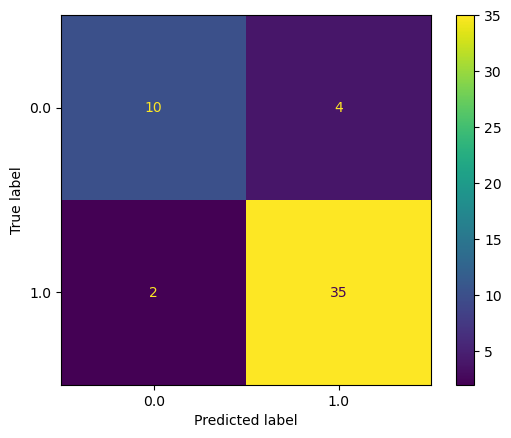

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(models[0], X_val, y_val)
plt.show()

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_val, models[0].predict(X_val)))

              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77        14
         1.0       0.90      0.95      0.92        37

    accuracy                           0.88        51
   macro avg       0.87      0.83      0.85        51
weighted avg       0.88      0.88      0.88        51

